In [51]:
import numpy as np
import math
import os
import random
import queue
import matplotlib.pyplot as pl

In [52]:
NP=5 #Number of processes
PAGE_SIZE=4096 #Page size in bytes
F=16 #Number of Frames
INVALID = -10
PID=0
FRAME = 1 #Used for indexing into frames
pr_timing = np.zeros(F).astype('int32')

COMPLETED=10
INCOMPLETE=20


IN_MEMORY = 1
MEM_FAULT = 50
PAGE_REPLACE = 100
FIFO_GLOBAL=10

phys_mem = np.full((F,2), INVALID).astype('int32') #Initial Physical memory addresses
phys_mem

array([[-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10]])

In [53]:
def init_proc_queue():
    pq=queue.Queue(maxsize=NP) #Create a queue of size of number of processes
    proc_queue=list(set((NP*np.random.random(20)).astype('int32'))) #creating a process queue
    random.shuffle(proc_queue) # Shuffle the list
    for pr in proc_queue:
        pq.put_nowait(pr)     #Put all process in queue
        
    print(proc_queue)
init_proc_queue()

[0, 3, 2, 4, 1]


In [54]:
def correct_refs(alist,cent,maxpg):
    if cent!=0:
        pgnum=int(cent/PAGE_SIZE)
        lh=(pgnum+1)*PAGE_SIZE-1
        ll=pgnum*PAGE_SIZE
    else:
        lh=maxpg*PAGE_SIZE
        ll=0
        
    for i in range(alist.shape[0]):
        if alist[i]>=lh:
            alist[i]=lh-1
        if alist[i]<ll:
            alist[i]=ll+1
    return alist

def sim_process(M,sigma,outfile,lfrac=0.9):
    cur_page=int(M*np.random.random()) #Generating random start page
    cur_locale=round(PAGE_SIZE*(cur_page+0.5)) #Generating location of current page
    sum_refs=0
    list_locales=list()
    for count in range(M):
        num_refs=int(512+(PAGE_SIZE-512)*np.random.random())
        sum_refs+=num_refs
        list_locales.append(cur_page)
        num_loc=round(lfrac*num_refs)
        aref_list=np.random.normal(cur_locale,sigma*300+100,num_loc)
        aref_list=correct_refs(aref_list,cur_locale,M)
        aref_list=aref_list.astype('int32')
        cur_page=int(M*np.random.random())
        cur_locale=round(PAGE_SIZE*(cur_page+0.5))
        num_trans=round((1-lfrac)*num_refs)
        tref_list=np.random.random(num_trans)*cur_locale
        tref_list=correct_refs(tref_list,0,M)
        tref_list=tref_list.astype('int32')
        np.append(aref_list,tref_list).tofile(outfile,sep='\n')
        outfile.write('\n')
    return list_locales,sum_refs
        
      
    print('Current Page',cur_page)
    print('Current Location',cur_locale)
    print('List of Locations',list_locales)
    
npg = int(np.random.normal(10,2.5))
nsig = int(5 * np.random.random())    
fname = 'AR_' + '{:02d}'.format(0) + '.txt'
fname=open(fname,'w')
sim_process(npg,nsig,fname)

([2, 6, 5, 6, 2, 2, 3], 22319)

In [55]:
int(512+(PAGE_SIZE-512)*np.random.random())

2601

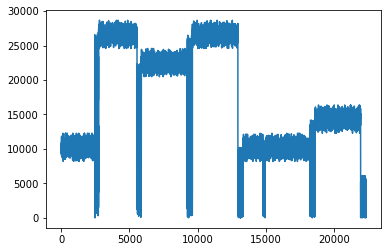

In [56]:
file=np.loadtxt('AR_00.txt')
pl.plot(file)

In [57]:
pr_size=np.zeros(NP,dtype='int32')

for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    op=open(fname,'w')
    npg=int(np.random.normal(10,2.5))
    nsig=int(5*np.random.random())
    print(f'Process {p} requires {npg} pages and has a quality {nsig}')
    pg_seq,pr_size[p]=sim_process(npg,nsig,op)
    print(pg_seq,pr_size[p])
    op.write('\n')
    op.close()
    print('written process',p,'to ',fname)

Process 0 requires 12 pages and has a quality 1
[3, 8, 9, 7, 3, 1, 2, 4, 9, 11, 7, 9] 27493
written process 0 to  AR_00.txt
Process 1 requires 3 pages and has a quality 2
[1, 2, 0] 7215
written process 1 to  AR_01.txt
Process 2 requires 5 pages and has a quality 3
[0, 3, 2, 4, 4] 11372
written process 2 to  AR_02.txt
Process 3 requires 14 pages and has a quality 1
[4, 11, 4, 3, 5, 10, 3, 9, 9, 11, 11, 12, 3, 5] 32375
written process 3 to  AR_03.txt
Process 4 requires 11 pages and has a quality 4
[6, 7, 7, 0, 6, 2, 3, 9, 1, 2, 3] 29002
written process 4 to  AR_04.txt


27492


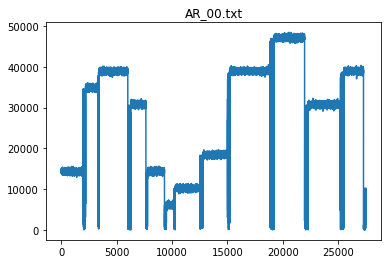

7215


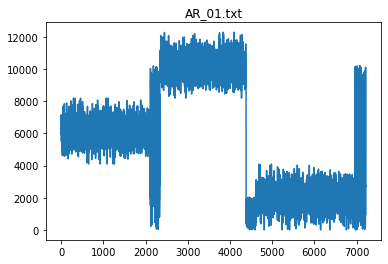

11372


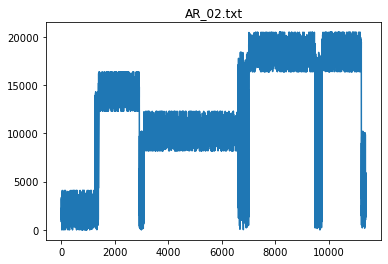

32374


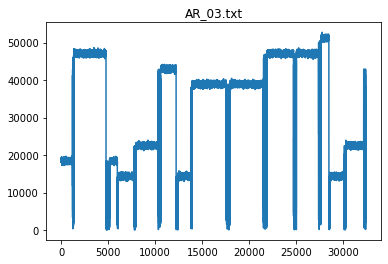

28999


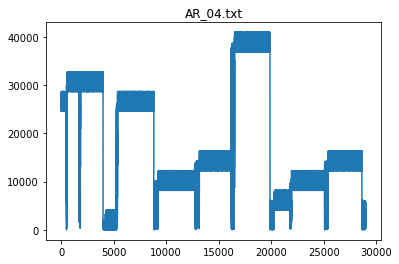

In [58]:
for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    temp=np.loadtxt(fname)
    print(len(temp))
    pl.plot(range(len(temp)),temp)
    pl.title(fname)
    pl.show()

In [59]:
def init_phys_mem():
    for i in range(F):           
        phys_mem[i,PID]=INVALID      #Initialize physical memory PID with empty
        phys_mem[i,FRAME]=INVALID    #Initialize physical memory frame with empty
        
init_phys_mem()

In [90]:
def update_phys_mem(pid):
    for i in range(F):                     
        if phys_mem[i,PID]==pid:
            #Execute the particular process  in that frame and make memory
            #available for other processes.
            
            phys_mem[i,PID]=INVALID        
            phys_mem[i,FRAME]=INVALID      

            
def memory_manager(infile,outfile,pid):
    num_adr=512+int(4096*np.random.random())
    idx=0 #counter to increase and read addresses.
    
    while idx<num_adr:
        add_ref=infile.readline().strip() #This will load all the address line by line
                                        #Also considered as virtual addresses.
        if add_ref=='':
            break #Finished reading address references
            
        add_ref=int(add_ref)  #Address reference
        pg_num=int(add_ref/PAGE_SIZE) #Page number to keep track of
        pg_offset=add_ref%PAGE_SIZE #Page offset.
        pg_base,pg_fault=get_pageframe(pg_num,pid) #Get page offset and page fault if occured 
                                                    #eslse initialize page for memory
        
        if pg_base>=0:
            phys_addr=pg_base+pg_offset            #Generating a physical address by adding both.
            outfile.write(str(add_ref)+','+str(phys_addr)+','
                         +str(pg_fault)+'\n')      #Copy logical address, physical address along 
                                                    #with page fault status in out file.
            
            if pg_fault==0:                #If returned value is 0 i.e load from memory.
                pr_timing[pid]+=IN_MEMORY
            elif pg_fault==1:              #IF returned value is 1 i.e memory fault occured
                pr_timing[pid]+=MEM_FAULT
            else:
                pr_timing[pid]+=PAGE_REPLACE #Page replacement algo being run.
                        
        else:
            print(idx)
            return INVALID
        idx+=1
    
    if idx>=num_adr:
        return INCOMPLETE
    
    return COMPLETED
            

def get_pageframe(pnum, pr) :
    fr_num = 0  #Initialize frame number to 0
    while fr_num < F : #Loop until counter reaches to all frames
        if phys_mem[fr_num,PID] == pr and phys_mem[fr_num,FRAME] == pnum : #if process is found in a frame, stop loop
            break                                                          #and keep track of frame number
        else :
            fr_num += 1  #Increase counter for frame

    if fr_num < F : #If the searched frame number is less than the available frames,
        return fr_num * PAGE_SIZE, 0 #Return frame number x 4096 i.e page base with page fault 0 i.e fault didnt occur.
                                    # Required page is in main memory and execute process.
    fr_num = gen_pagefault(pnum, pr) #Since frame number was greater than frame size so generate page fault.
                                    #So search for the frame and try to load in physical memory
    
    if fr_num>=0:  #check for the frame number returned from pagefault and return page fault occured once.
        return fr_num*PAGE_SIZE,1
    
    fr_num=page_replace(pnum,pr) #Running page replacement algorithm. Since page has to be 
                                #Loaded into physical memory.
    
    if fr_num>=0: 
        return fr_num*PAGE_SIZE,2 #This is to replace the page into main memory
    
    return INVALID,0 #If the required frame is not found, return Invalid
    
    
    
def gen_pagefault(pgnum, pr) :
    fr_num = 0 #Initialize frame number to 0
    while fr_num < F and phys_mem[fr_num,FRAME] >= 0 : #Loop untill frame number is not less than Frame number
        #and physical memory's frame number,Frame index >=0 i.e valid. It is searching for a page
        #inside main memory.  This is to check whether hit or fault is occured or not.
            
        fr_num += 1                                    # Increment frame number.
    
    if fr_num >= F :  #If frame number is greater than Frame Size than its Invalid i.e it is not present in memory.
        return INVALID
    
    #If fault didnt occur than  update physical memory and execute the process
    phys_mem[fr_num,FRAME] = pgnum     #Update physical memory with current page number
    phys_mem[fr_num,PID] = pr          #update physical memory with current process id
    
    return fr_num                      #return frame number in which Hit was occured.
        

  
def get_oldest_frame(pr,algo_type):
    global oldest_frame              #Access to the variable global_frame assigned
    if algo_type==FIFO_GLOBAL:      #IF algorithm is FIFO GLOBAL ,
        rv=oldest_frame            #temporary variable to store value of oldest_frame
        oldest_frame+=1           #Increase the value of oldest frame by 1 as it is accessed once
        if oldest_frame==F:      # If oldest frame reaches to max, again make it 0 to start
            oldest_frame=0       #So as to form a cycle and make frame available to all process
        return rv
    return INVALID
    



def page_replace(pgnum,pr,algo=FIFO_GLOBAL):
    current_frame=get_oldest_frame(pr,algo)  #Get track of previous frame so as to update the last
                                            #Frame in which process was executed and replace that 
                                            #with the new process to execute.
    phys_mem[current_frame,PID]=pr          #Update physical memory and execute process with the 
                                            #Current process ID.
    phys_mem[current_frame,FRAME]=pgnum     #Update physical memory and execute process with the 
                                            #Current page number.
    return current_frame                    #Return current frame in which page was loaded.

    
def print_phys_mem():
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    for i in range(F):                 #Run for loop for 16 times and print status of all
        if phys_mem[i,PID]!=INVALID:
            print('{:^10d} {:^6d} {:^6d}'.format(i,phys_mem[i,PID],phys_mem[i,FRAME]))
        else:
            print('Free Frame: ',i)
    

    
def ready_queue(q):  #Trying to read processes from ready queue
    while True:
        try:
            yield q.get_nowait()    #Try to get the process from queue
        except queue.Empty:
            break                   #If the queue is empty, Break.
    
print_phys_mem()


  Frame     PID   Page No.
  -----     ---   --------
Free Frame:  0
Free Frame:  1
Free Frame:  2
Free Frame:  3
Free Frame:  4
Free Frame:  5
Free Frame:  6
Free Frame:  7
Free Frame:  8
Free Frame:  9
Free Frame:  10
Free Frame:  11
Free Frame:  12
Free Frame:  13
Free Frame:  14
Free Frame:  15


In [61]:
phys_mem[3]

array([-10, -10])

In [62]:
file=pd.read_csv('AR_00out.txt',names=['a','b','c'])

<IPython.core.display.Javascript object>

In [63]:
file.head()

,a,b,c
0,31678,3006,0
1,30460,1788,0
2,30600,1928,0
3,29427,755,0
4,31641,2969,0


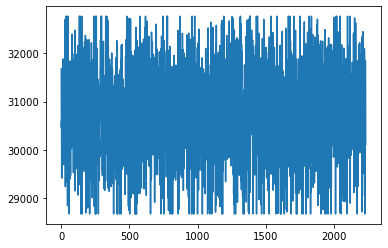

In [64]:
file['a'].plot()

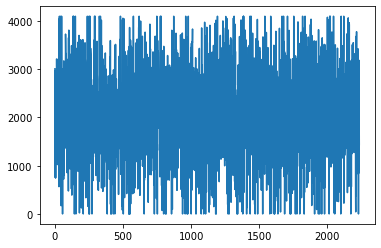

In [65]:
file['b'].plot()

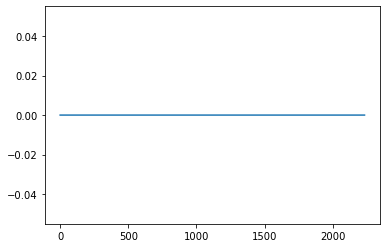

In [66]:
file['c'].plot()

(array([ 3.,  3.,  5., 16., 16., 15., 13., 15.,  9.,  5.]),
 array([ 3.83390858,  4.9559716 ,  6.07803463,  7.20009765,  8.32216068,
         9.4442237 , 10.56628673, 11.68834975, 12.81041277, 13.9324758 ,
        15.05453882]),
 <a list of 10 Patch objects>)

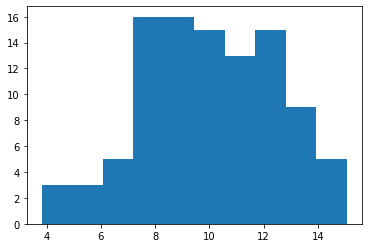

In [67]:
pl.hist([np.random.normal(10,2.5) for i in range(100)])

0 2048


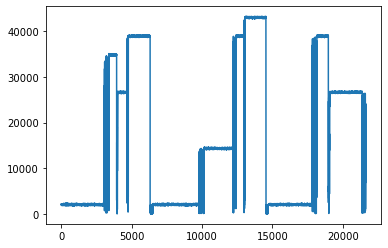

In [68]:
Page_size=4096
lfrac=0.9
M=int(np.random.normal(10,2.5))
cur_page=int(M*np.random.random())  #Starts with a random page....
cur_locale=round(Page_size*(cur_page+0.5)) #Starts with a some 
sigma=int(10 * np.random.random())
sum_refs=0
print(cur_page,cur_locale)
list_locales=list()
outfile=open('test.txt','w')
c_outfile=open('c_test.txt','w')

for count in range(M):
    num_refs=int(512+(Page_size-512)*np.random.random())
    sum_refs+=num_refs
    list_locales.append(cur_page)
    num_loc=round(lfrac*num_refs)
    aref_list=np.random.normal(cur_locale,sigma*300+100,num_loc)
    c_aref_list = correct_refs(aref_list, cur_locale, M)
    aref_list=aref_list.astype('int32')
    c_aref_list=c_aref_list.astype('int32')
    cur_page=int(M*np.random.random())
    cur_locale=round(Page_size*(cur_page+0.5))
    num_trans=round((1-lfrac)*num_refs)
    tref_list=np.random.random(num_trans)*cur_locale
    c_tref_list = correct_refs(tref_list, 0, M)
    tref_list=tref_list.astype('int32')
    c_tref_list=c_tref_list.astype('int32')

    np.append(aref_list, tref_list).tofile(outfile, sep='\n')
    outfile.write('\n')
    
    np.append(c_aref_list,c_tref_list).tofile(c_outfile, sep='\n')
    c_outfile.write('\n')
    
outfile.close()
c_outfile.close()
txt=np.loadtxt('test.txt')
c_txt=np.loadtxt('c_test.txt')
pl.plot(txt)

# M,cur_page,cur_locale,sum_refs,list_locales,num_loc

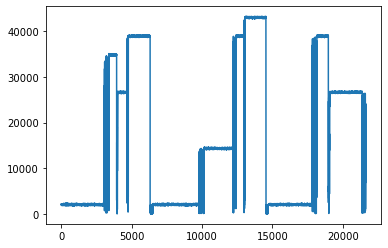

In [69]:
pl.plot(c_txt)

In [70]:
M,cur_page,cur_locale,sum_refs,list_locales,num_loc

(11, 6, 26624, 21629, [0, 8, 6, 9, 0, 3, 9, 10, 0, 9, 6], 2307)

In [71]:
NP=5
pr=queue.Queue(maxsize=NP)
proc_queue=list(set((NP*np.random.random(20)).astype(int)))
random.shuffle(proc_queue)
for pq in proc_queue:
    pr.put_nowait(pq)
proc_queue,pr

([2, 0, 3, 1, 4], <queue.Queue at 0x27f38394888>)

In [72]:
for i in range(NP):
    print(pr.get_nowait())

2
0
3
1
4


In [73]:
#alist is aref and tref list., cent is current locale, m is max size.
def correct_refs_(alist,cent,maxpg):
    if cent!=0:
        pgnum=int(cent/PAGE_SIZE)
        lh=(pgnum+1)*PAGE_SIZE-1
        ll=pgnum*PAGE_SIZE
    else:
        lh=maxpg*PAGE_SIZE
        ll=0
        
    for i in range(alist.shape[0]):
        if alist[i]>lh:
            alist[i]=lh-1
        if alist[i]<ll:
            alist[i]=ll+1
    return alist
        
        
        

In [74]:
len(txt),len(c_txt)

(21629, 21629)

In [75]:
(txt==c_txt).sum()

21629

In [76]:
def get_oldest_frame(pr,algo_type):
    global oldest_frame
    if algo_type==FIFO_GLOBAL:
        rv=oldest_frame
        oldest_frame+=1
        if oldest_frame==F:
            oldest_frame=0
        return rv
    return INVALID

def init_phys_mem():
    for i in range(F):
        phys_mem[i,PID]=INVALID
        phys_mem[i,FRAME]=INVALID

def update_phys_mem(pid):
    for i in range(F):
        if phys_mem[i,PID]==pid:
            phys_mem[i,PID]=INVALID
            phys_mem[i,FRAME]=INVALID
# When the required process id is found in the memory, execute the process
# and make the physical memory available
    


In [77]:
def memm(infile,outfile,pid):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-77-e0cec39f717c>, line 2)

In [ ]:
pr_size=np.zeros(NP,dtype='int32')

for p in range(NP):
    fname='Temp'+'{:02d}'.format(p)+'.txt'
    npg=int(np.random.normal(10,2.5))
    nsig=int(5*np.random.random())
    print(f' Process {p} requires {npg} pages and has quality {nsig}')
    pg_seq,pr_size[p]=sim_process(npg,nsig,op)
    print(pg_seq,pr_size[p])

pr_size